In [23]:
%load_ext autoreload
%autoreload 2

from deltas.pipeline import data, classifier, evaluation
from deltas.model import base, downsample
import deltas.plotting.plots as plots
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# np.random.seed(10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

N1 = 1000
N2 = 10
m = 1
v = 1
costs = (1, 1)  # change for (1, 10) to increase results
# Gaussian (not always seperable)
runs = [6, 10, 100, 500, 1000]
results = {}
for run in tqdm(runs):
    N2 = run
    dfs = []
    while len(dfs) < 2:
        data_clf = data.get_data(
            m1=[-m, -m],
            m2=[m, m],
            cov1=[[v, 0], [0, v]],
            cov2=[[v, 0], [0, v]],
            N1=N1,
            N2=N2,
            scale=False,
            test_nums=[10000, 10000],
        )

        model = 'SVM-linear'
        model = 'SVM-rbf'
        # model = 'Linear'
        model = 'MLP'

        classifiers_dict = classifier.get_classifier(
            data_clf=data_clf,
            model=model,
            _plot=False)
        data_clf['clf'] = classifiers_dict['Baseline']
        X = data_clf['data']['X']
        y = data_clf['data']['y']
        clf = data_clf['clf']
        # deltas_model = downsample.downsample_deltas(
        #     clf).fit(X, y, _print=True, _plot=True, max_trials=10000)
        # deltas_model = base.base_deltas(
        #     clf).fit(X, y, grid_search=True, _print=True, _plot=True)
        deltas_model = downsample.downsample_deltas(clf).fit(X, y,
                                                            alpha=10,
                                                            _print=False,
                                                            _plot=False,
                                                            method='supports-prop-update_mean',
                                                            max_trials=10000,
                                                            parallel=True)

        if deltas_model.is_fit == True:
            classifiers_dict['Our Method'] = deltas_model
            scores_df = evaluation.eval_test(classifiers_dict,
                                            data_clf['data_test'], _print=False, _plot=False)
            dfs.append(scores_df)
        else:
            print('not fit deltas')
    results[run] = dfs

  0%|          | 0/5 [00:00<?, ?it/s]

/home/matt/anaconda3/envs/deltas/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|██        | 1/5 [00:20<01:21, 20.36s/it]/home/matt/anaconda3/envs/deltas/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/matt/anaconda3/envs/deltas/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 5/5 [01:47<00:00, 21.44s/it]


In [4]:
print(results[runs[0]])

[                  Accuracy    G-Mean   ROC-AUC        F1
Method                                                  
Baseline           0.51555  0.176352  0.936134  0.060324
SMOTE              0.80620  0.784403  0.954306  0.761858
Balanced Weights   0.83375  0.818978  0.976522  0.802963
BMR                0.74815  0.705727  0.936134  0.664937
Threshold          0.74815  0.705727  0.936134  0.664937
Our Method         0.82205  0.804898  0.936134  0.786362,                   Accuracy    G-Mean   ROC-AUC        F1
Method                                                  
Baseline           0.50000  0.000000  0.969953  0.000000
SMOTE              0.84950  0.842111  0.952181  0.830556
Balanced Weights   0.78835  0.762885  0.945809  0.735850
BMR                0.90120  0.900411  0.969953  0.897329
Threshold          0.90120  0.900411  0.969953  0.897329
Our Method         0.88615  0.882724  0.969953  0.876539]


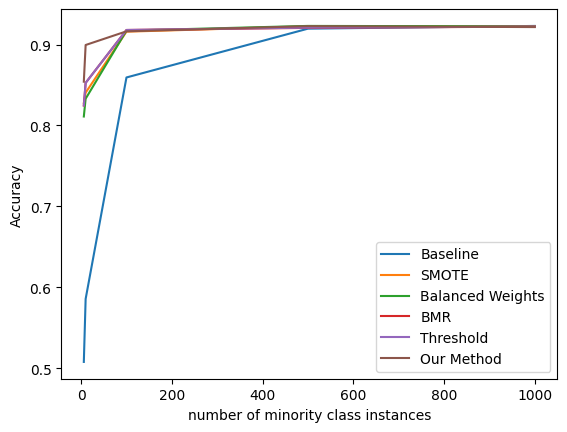

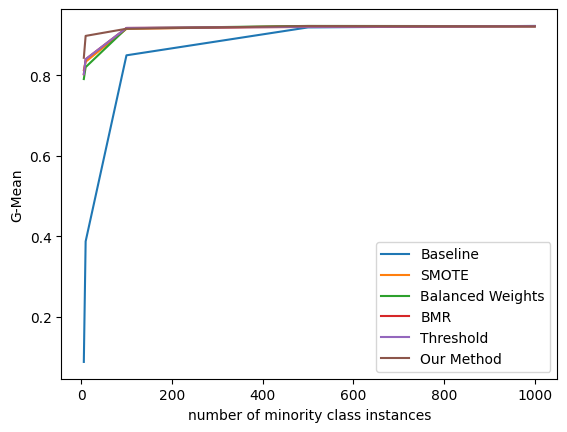

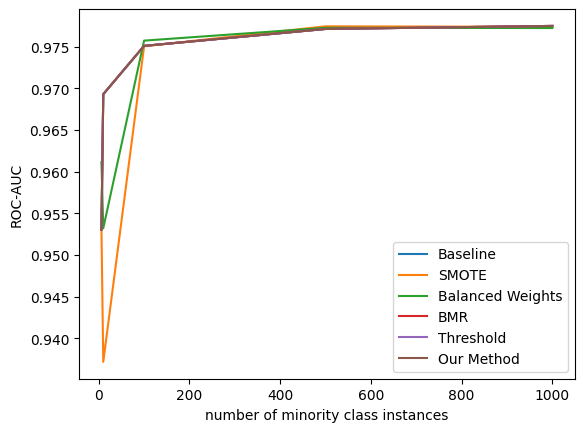

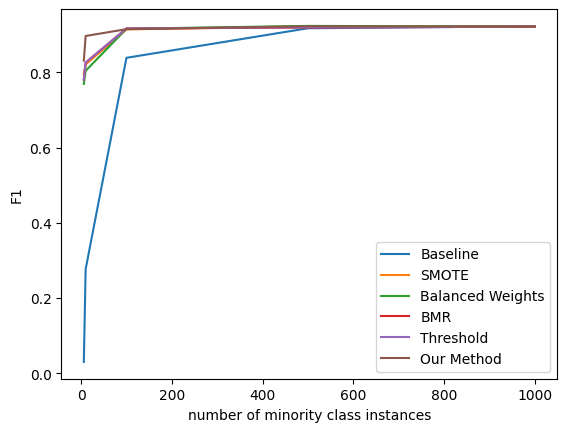

In [24]:
# setup data storage for plots
metrics = results[runs[0]][0].columns.to_list()
methods = results[runs[0]][0].index.to_list()
plot_info = {}
for metric in metrics:
    plot_info[metric] = {}
    for method in methods:
        plot_info[metric][method] = []

# extract data for plotting
for run in runs:
    dfs = results[run]
    df = pd.concat(dfs, axis=0)
    mean = {}
    std = {}
    index = df.index.unique().to_list()
    cols = df.columns.to_list()
    for method in index:
        mean[method] = df.loc[method].mean().to_list()
        std[method] = df.loc[method].std().to_list()
    for metric in cols:
        for method in mean.keys():
            plot_info[metric][method].append(mean[method][cols.index(metric)])
    
# plot 
for metric in metrics:
    for method in methods:
        plt.plot(runs, plot_info[metric][method], label=method)
    plt.legend()
    plt.ylabel(metric)
    plt.xlabel('number of minority class instances')
    plt.show()